In [305]:
import pandas as pd
import numpy as np

In [306]:
training=pd.read_csv('house-prices-advanced-regression-techniques/train.csv',index_col='Id')
test_x=pd.read_csv('house-prices-advanced-regression-techniques/test.csv',index_col='Id')
train_x=training.iloc[:,:-1]
train_y=training.iloc[:,-1]
test_y=pd.read_csv('house-prices-advanced-regression-techniques/sample_submission.csv',index_col='Id')

In [307]:
data=pd.concat([train_x,test_x])
data=data.fillna({'Alley':'NA','BsmtQual':'NA','BsmtCond':'NA','BsmtExposure':'NA','BsmtFinType1':'NA','BsmtFinType2':'NA','FireplaceQu':'NA','GarageType':'NA','GarageFinish':'NA','GarageQual':'NA','GarageCond':'NA','PoolQC':'NA','Fence':'NA','MiscFeature':'NA','Exterior2nd':'NA'})
cate=['MSZoning','Utilities','Exterior1st','MasVnrType','Electrical','KitchenQual','Functional','GarageYrBlt','SaleType']
for item in cate:
    data[item]=data[item].fillna(data[item].value_counts().index[0])
tem=np.where(data['MasVnrType']=='None',0,data['MasVnrArea'])
data['MasVnrArea']=data['MasVnrArea'].fillna(pd.Series(tem))
tem=np.where(data['BsmtFinType1']=='NA',0,data['BsmtFinSF1'])
data['BsmtFinSF1']=data['BsmtFinSF1'].fillna(pd.Series(tem))
tem=np.where(data['BsmtFinType2']=='NA',0,data['BsmtFinSF2'])
data['BsmtFinSF2']=data['BsmtFinSF2'].fillna(pd.Series(tem))
tem=np.where(data['BsmtQual']=='NA',0,data['BsmtUnfSF'])
data['BsmtUnfSF']=data['BsmtUnfSF'].fillna(pd.Series(tem))
tem=np.where(data['BsmtQual']=='NA',0,data['BsmtHalfBath'])
data['BsmtHalfBath']=data['BsmtHalfBath'].fillna(pd.Series(tem))
tem=np.where(data['BsmtQual']=='NA',0,data['BsmtFullBath'])
data['BsmtFullBath']=data['BsmtFullBath'].fillna(pd.Series(tem))
tem=np.where(data['GarageType']=='NA',0,data['GarageCars'])
data['GarageCars']=data['GarageCars'].fillna(pd.Series(tem))
tem=np.where(data['GarageType']=='NA',0,data['GarageArea'])
data['GarageArea']=data['GarageArea'].fillna(pd.Series(tem))
data['LotFrontage']=data['LotFrontage'].fillna(np.nanmedian(data['LotFrontage']))
data['TotalBsmtSF']=(data['BsmtFinSF1']+data['BsmtFinSF2']+data['BsmtUnfSF'])
data['TotalSF']=data['TotalBsmtSF']+data['1stFlrSF']+data['2ndFlrSF']
data['Total_sqr_footage'] = (data['BsmtFinSF1']+data['BsmtFinSF2']+data['1stFlrSF']+data['2ndFlrSF'])
data['Total_Bathrooms'] = (data['FullBath'] + (0.5*data['HalfBath'])+data['BsmtFullBath']+(0.5*data['BsmtHalfBath']))
data['Total_porch_sf'] = (data['OpenPorchSF']+data['3SsnPorch']+data['EnclosedPorch'] + data['ScreenPorch']+data['WoodDeckSF'])

In [308]:
train_x=data.iloc[0:1460,:]
test_x=data.iloc[1460:,:]
training=train_x.join(train_y)
testing=test_x.join(test_y)
training.head()
c=training.corr()
c['SalePrice'].sort_values()

KitchenAbvGr        -0.135907
EnclosedPorch       -0.128578
MSSubClass          -0.084284
OverallCond         -0.077856
YrSold              -0.028923
LowQualFinSF        -0.025606
MiscVal             -0.021190
BsmtHalfBath        -0.016844
BsmtFinSF2          -0.011378
3SsnPorch            0.044584
MoSold               0.046432
PoolArea             0.092404
ScreenPorch          0.111447
BedroomAbvGr         0.168213
BsmtUnfSF            0.214479
BsmtFullBath         0.227122
LotArea              0.263843
HalfBath             0.284108
OpenPorchSF          0.315856
2ndFlrSF             0.319334
WoodDeckSF           0.324413
LotFrontage          0.334544
BsmtFinSF1           0.386420
Total_porch_sf       0.390993
GarageYrBlt          0.397778
Fireplaces           0.466929
MasVnrArea           0.472645
YearRemodAdd         0.507101
YearBuilt            0.522897
TotRmsAbvGrd         0.533723
FullBath             0.560664
1stFlrSF             0.605852
TotalBsmtSF          0.613581
GarageArea

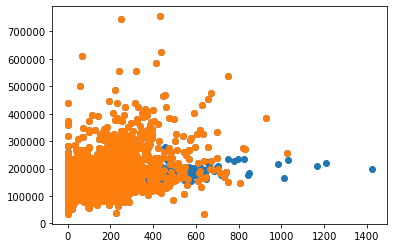

In [309]:
import seaborn as sns
from scipy.stats import skew
import matplotlib.pyplot as plt
plt.scatter(x=data['Total_porch_sf'],y=pd.concat([training,testing])['SalePrice'])
plt.scatter(x=train_x['Total_porch_sf'],y=train_y)
#plt.scatter(x=test_x['TotalSF'],y=test_y)

In [310]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline
train_x1=train_x[['Total_sqr_footage','Total_porch_sf']]
train_y1=np.log(train_y)
test_x1=test_x[['Total_sqr_footage','Total_porch_sf']]
test_y1=np.log(test_y)
regressor = LinearRegression()
regressor.fit(train_x1, train_y1)
y_pred = regressor.predict(test_x1)
print('Mean Absolute Error:', metrics.mean_absolute_error(test_y1, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(test_y1, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y1, y_pred)))
print('R-squared Error:', metrics.r2_score(test_y1.values.reshape(-1,1), y_pred))

Mean Absolute Error: 0.2173779457400908
Mean Squared Error: 0.07224707941301016
Root Mean Squared Error: 0.2687881682905893
R-squared Error: -7.915032353744881
